# Ranger Walk-through: Information Retrieval

In this notebook we'll walk you through on how to use *ranger* for multi-collection information retrieval evaluation using data from the [ColBERTer](https://arxiv.org/abs/2203.13088) paper. 

We make use of the awesome [ir_measures](https://github.com/terrierteam/ir_measures) library, to compute our IR metrics!

This guide assumes you already installed ranger via pip. Let's get started by defining the location of our results and what we want to compare:

In [1]:
from ir_measures import nDCG, Judged
import os

from ranger.retrieval.data_pipeline import load_and_compute_metrics
from ranger.retrieval.config_location import RetrievalLocationConfig

#
# settings
#
# the example config & result data features results from 7 common retrieval collections
config = RetrievalLocationConfig("./retrieval-colberter-data/config.yaml")

title = 'TAS-B vs. Uni-ColBERTer (Dim1, BOW$^2$ + CS)'
control_rankings = "tasb_dim768_hf"  # this is a key in the config.yaml file
treatment_rankings = "colberter_dim1"  # this is also a key in the config.yaml file

# you can select any measure and setting provided by ir_measures, we choose nDCG@10
measure = nDCG(judged_only=False)@10
measure_str = "nDCG@10"

#
# load & compute metrics for the control and treatment experiments
#
control_data = load_and_compute_metrics(control_rankings, measure, config)
treatment_data = load_and_compute_metrics(treatment_rankings, measure, config)

Now that we have loaded up our data and computed run-wise metrics over multiple tasks we can move on to computing the effect size comparing control and treatment experiments:

In [2]:
#from ranger.effect_size_analysis import effect_size_analysis_calculation
#
#effect_size = effect_size_analysis_calculation(list(config.display_names.values()),
#                                               treatment_metrics=treatment_data,
#                                               control_metrics=control_data,
#                                               effect_size_method="SMD")
#effect_size

from ranger.metric_containers import AggregatedPairedMetrics
from ranger.meta_analysis import analyze_effects

effects = AggregatedPairedMetrics(
    treatment=treatment_data.get_metrics(),
    control=control_data.get_metrics()
)
effect_size = analyze_effects(list(config.display_names.values()),
                              effects=effects,
                              effect_type="MD")
effect_size


,eff,ci_low,ci_upp,p,w_re
TREC Covid,0.184815,0.103532,0.266098,8.334601e-06,0.062203
TripClick,0.008639,0.002441,0.014837,6.297873e-03,0.168418
NFCorpus,0.007292,-0.001984,0.016567,1.233609e-01,0.166358
DBPedia Entity,0.031409,0.019186,0.043631,4.738662e-07,0.163695
Antique,0.122602,0.101534,0.143670,0.000000e+00,0.152359
TREC Podcast,0.025695,-0.006533,0.057922,1.181383e-01,0.133663
TREC Robust 04,0.029387,0.008951,0.049824,4.825404e-03,0.153305
combined_effect,0.045925,0.020472,0.071378,4.057094e-04,1.000000


That's too many numbers!! Who can make sense of this wall of numbers? No one in any sensible amount of time! Therefore, let's feed our effect size results into ranger's forest plot method, to create a beautifully rendered & customizable figure:

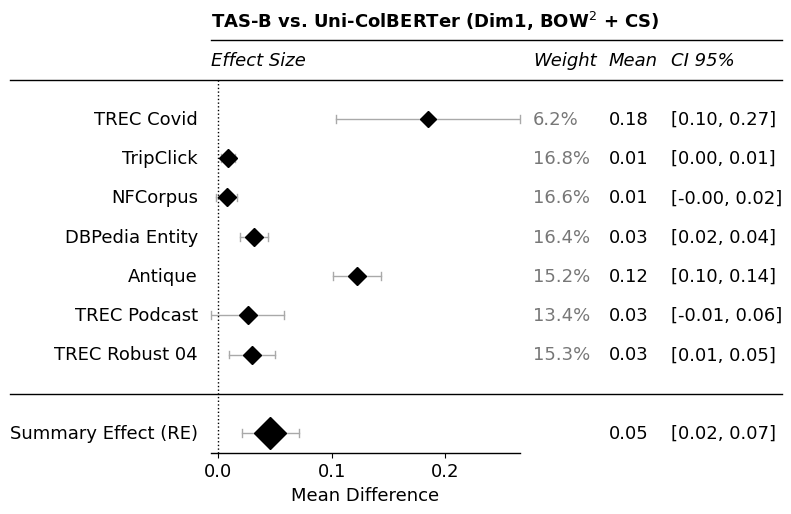

In [3]:
from ranger.forest_plots import forest_plot

plot = forest_plot(
    title=title,
    experiment_names=list(config.display_names.values()),
    label_x_axis="Mean Difference",
    effect_size=effect_size,
    fig_width=8,
)


Much better! Right now the forest plot only contains effect-size information. We might want to extend the information density here to include extra data (such as the raw values, or a IR specific measure the Judgement rate J@k). We can extend either side of the effect-size plot with more columns. In this example we add 2 columns to the right. 

*Note, how we purposefully leave the summary line empty - because the raw values should not be averaged.*

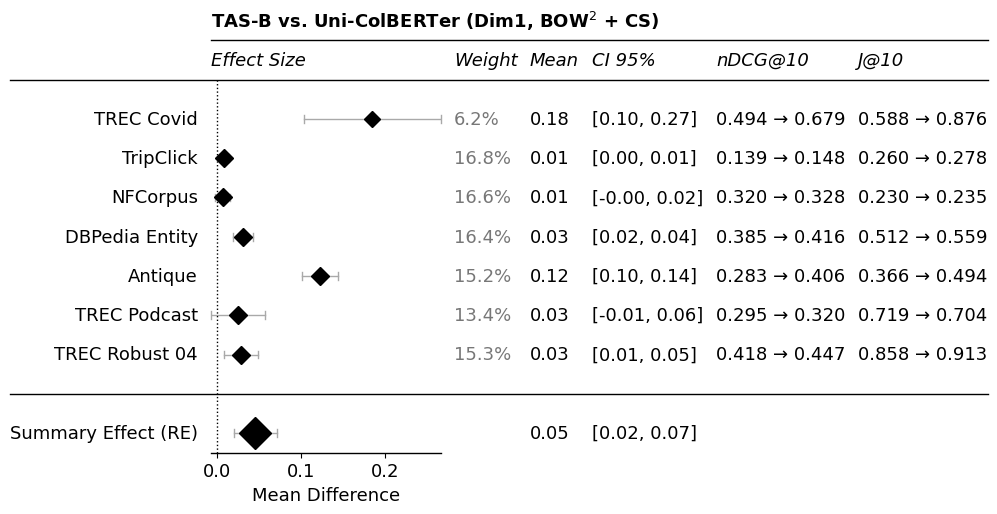

In [4]:
# add raw values from the already computed metrics
extra_columns = [[], []]
for i, control in enumerate(control_data.get_means()):
    extra_columns[0].append("{:.3f}".format(control)+" → "+"{:.3f}".format(treatment_data.get_means()[i]))

# compute a second set of metrics (here Judged@10)
control_judgement_rate = load_and_compute_metrics(control_rankings, Judged@10, config)
treatment_judgement_rate = load_and_compute_metrics(treatment_rankings, Judged@10, config)

# fill the second column with the new metrics
for i, control in enumerate(control_judgement_rate.get_means()):
    extra_columns[1].append("{:.3f}".format(control)+" → "+"{:.3f}".format(treatment_judgement_rate.get_means()[i]))

extra_column_headers = [measure_str, "J@10"]
extra_column_summary = ["", ""]


plot = forest_plot(
    title=title,
    experiment_names=list(config.display_names.values()),
    label_x_axis="Mean Difference",
    effect_size=effect_size,
    fig_width=10,
    add_right_columns=extra_columns,
    add_right_column_headers=extra_column_headers,
    add_right_column_summary=extra_column_summary,
)


Awesome! Let's save the figure, so that we can use it to inform our result presentation:

In [5]:
fig_name = "./sample/"+control_rankings+"_vs_"+treatment_rankings

# save as svg for web display
plot.savefig(fname=fig_name+".svg", dpi=300, bbox_inches='tight')

# save as pdf for latex integration
plot.savefig(fname=fig_name+".pdf", dpi=300, bbox_inches='tight')
